In [2]:
import numpy as np, random, pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, KFold
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Fix random seeds for reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

# Custom frequency encoder (as in original code)
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.freq_maps = {col: X[col].value_counts(normalize=True) for col in X.columns}
        return self
    def transform(self, X):
        X_trans = X.copy()
        for col, freq_map in self.freq_maps.items():
            X_trans[col] = X_trans[col].map(freq_map).fillna(0.0)
        return X_trans

# Load dataset
df = pd.read_excel("EPDs_cleaned_harmonized.xlsx", engine='openpyxl')
df_ext = pd.read_excel("validation_set.xlsx", engine='openpyxl')  # external validation set

target_col = "GWPtotal (A2)"
X = df.drop(columns=[target_col])
y = df[target_col].values
X_ext = df_ext.drop(columns=[target_col])
y_ext = df_ext[target_col].values

# Define column groups for preprocessing
high_card_cols   = ["Name (en)", "Category", "Reference Flow Name"]
medium_card_cols = ["Country code", "Modul", "Reference unit"]
numeric_cols     = ["Reference size", "PERT", "PENRT", "SM", "NHWD", "RWD"]

# Preprocessing pipeline: frequency encode high-cardinality, one-hot encode medium-card, scale numeric
preprocessor = ColumnTransformer(transformers=[
    ("freq_high",   FrequencyEncoder(), high_card_cols),
    ("onehot_med",  OneHotEncoder(drop="first", sparse_output=False, handle_unknown="ignore"), medium_card_cols),
    ("scale_num",   StandardScaler(), numeric_cols)
])

# Split data into training and internal test set
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, shuffle=True
)
# (Optional) Further split training data if needed (e.g., for ANN tuning)
# X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=SEED)

# We will perform cross-validation on X_train_full (80% of data) for hyperparameter tuning.
# Use 5-fold CV with fixed random state for reproducibility
cv = KFold(n_splits=5, shuffle=True, random_state=SEED)



#SUpport Vector Regression

In [3]:
from sklearn.svm import SVR

# SVR pipeline
svr_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor",  SVR(kernel='rbf'))
])

# SVR hyperparameter grid
svr_param_grid = {
    "regressor__C": [1, 10, 50, 100],        # candidate regularization strengths
    "regressor__epsilon": [0.1, 0.2, 0.5],   # how much error to tolerate 
    "regressor__gamma": [0.1, 0.5, 1.0]      # kernel coefficient for 'rbf'
}
# (If including 'linear' kernel, treat it separately or include conditional grid; here we focus on RBF)

svr_grid = GridSearchCV(svr_pipeline, svr_param_grid, cv=cv, scoring="r2", n_jobs=-1)
svr_grid.fit(X_train_full, y_train_full)
print("Best SVR Params:", svr_grid.best_params_)
svr_best_model = svr_grid.best_estimator_



Best SVR Params: {'regressor__C': 50, 'regressor__epsilon': 0.2, 'regressor__gamma': 0.5}


In [4]:
from sklearn.tree import DecisionTreeRegressor

tree_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor",  DecisionTreeRegressor(random_state=SEED))
])
tree_param_grid = {
    "regressor__max_depth": [5, 10, 20, None],        # limit tree depth
    "regressor__min_samples_split": [10, 20, 30, 40], # minimum samples to split an internal node
    "regressor__min_samples_leaf": [1, 2, 4, 5]       # minimum samples at a leaf node
}
tree_grid = GridSearchCV(tree_pipeline, tree_param_grid, cv=cv, scoring="r2", n_jobs=-1)
tree_grid.fit(X_train_full, y_train_full)
print("Best Decision Tree Params:", tree_grid.best_params_)
tree_best_model = tree_grid.best_estimator_


Best Decision Tree Params: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 10}


In [5]:
from sklearn.ensemble import RandomForestRegressor

rf_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor",  RandomForestRegressor(random_state=SEED, n_jobs=-1))
])
# Random Forest hyperparameter distributions/ranges
rf_param_dist = {
    "regressor__n_estimators": [500, 800, 1000, 1200, 1500],  # number of trees
    "regressor__max_depth": [10, 20, 30, None],               # max depth of trees
    "regressor__min_samples_split": [2, 5, 10, 15],           # min samples to split
    "regressor__min_samples_leaf": [1, 2, 4, 6]               # min samples at leaf
}
rf_random = RandomizedSearchCV(rf_pipeline, rf_param_dist, n_iter=50, cv=cv, scoring="r2", 
                               n_jobs=-1, random_state=SEED, verbose=1)
rf_random.fit(X_train_full, y_train_full)
print("Best RF Params:", rf_random.best_params_)
rf_best_model = rf_random.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best RF Params: {'regressor__n_estimators': 1500, 'regressor__min_samples_split': 2, 'regressor__min_samples_leaf': 1, 'regressor__max_depth': 20}


In [6]:
from xgboost import XGBRegressor

xgb_pipeline = Pipeline([
    ("preprocess", preprocessor),
    ("regressor",  XGBRegressor(objective='reg:squarederror', n_jobs=-1, random_state=SEED))
])
xgb_param_dist = {
    "regressor__n_estimators": [100, 300, 500, 1000],    # number of boosting rounds
    "regressor__max_depth": [3, 6, 10, 15],              # tree depth
    "regressor__learning_rate": [0.01, 0.05, 0.1, 0.2],  # step size shrinkage
    "regressor__subsample": [0.4, 0.6, 0.8, 1.0],        # fraction of data to sample for each tree
    "regressor__colsample_bytree": [0.6, 0.8, 1.0]       # fraction of features to sample for each tree
}
xgb_random = RandomizedSearchCV(xgb_pipeline, xgb_param_dist, n_iter=50, cv=cv, scoring="r2", 
                                n_jobs=-1, random_state=SEED, verbose=1)
xgb_random.fit(X_train_full, y_train_full)
print("Best XGB Params:", xgb_random.best_params_)
xgb_best_model = xgb_random.best_estimator_


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGB Params: {'regressor__subsample': 0.4, 'regressor__n_estimators': 1000, 'regressor__max_depth': 10, 'regressor__learning_rate': 0.01, 'regressor__colsample_bytree': 0.8}


In [7]:
import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

# Ensure reproducibility for ANN training
tf.random.set_seed(SEED)
# (Make sure to also set PYTHONHASHSEED, and other seeds as done above for full reproducibility)

# Prepare data for ANN (we use the preprocessed numpy arrays from earlier steps)
X_train_ann = preprocessor.fit_transform(X_train_full)  # fit on full training data
X_test_ann  = preprocessor.transform(X_test)
X_ext_ann   = preprocessor.transform(X_ext)
y_train_ann = y_train_full  # using full training set for final model tuning

def build_ann_model(hp):
    model = keras.Sequential()
    # Hyperparameters to tune:
    num_hidden = hp.Choice('num_hidden_layers', [1, 2, 3, 4])
    # First hidden layer
    units1 = hp.Int('units1', min_value=64, max_value=256, step=32)
    model.add(keras.layers.Dense(units1, activation='relu', input_shape=(X_train_ann.shape[1],)))
    dropout1 = hp.Float('dropout_1', min_value=0.1, max_value=0.5, step=0.1)
    model.add(keras.layers.Dropout(dropout1))
    # Additional hidden layers if num_hidden > 1
    if num_hidden >= 2:
        units2 = hp.Int('units2', min_value=32, max_value=128, step=32)
        model.add(keras.layers.Dense(units2, activation='relu'))
        dropout2 = hp.Float('dropout_2', min_value=0.1, max_value=0.5, step=0.1)
        model.add(keras.layers.Dropout(dropout2))
    if num_hidden >= 3:
        units3 = hp.Int('units_3', min_value=16, max_value=64, step=16)
        model.add(keras.layers.Dense(units3, activation='relu'))
        # (If num_hidden == 4, one could add a fourth layer similarly)
    # Output layer
    model.add(keras.layers.Dense(1, activation='linear'))
    # Learning rate
    learning_rate = hp.Choice('learning_rate', [0.001, 0.0005, 0.0001])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), 
                  loss='mse', metrics=['mae'])
    return model

tuner = kt.RandomSearch(
    build_ann_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    seed=SEED,
    directory='ann_tuning',
    project_name='GWP_ANN_tuning',
    overwrite=True
)
# Run hyperparameter search with early stopping
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
tuner.search(X_train_ann, y_train_ann, validation_split=0.2, epochs=50, batch_size=32, callbacks=[early_stop], verbose=0)

# Get the best hyperparameters and model
best_hp = tuner.get_best_hyperparameters(1)[0]
print("Best ANN Hyperparameters:", best_hp.values)
best_ann_model = tuner.get_best_models(1)[0]  # this model already has weights from best trial

# Evaluate the best ANN on test and external data
y_pred_ann_test = best_ann_model.predict(X_test_ann).flatten()
y_pred_ann_ext  = best_ann_model.predict(X_ext_ann).flatten()


c:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\user\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:92: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Best ANN Hyperparameters: {'num_hidden_layers': 4, 'units1': 128, 'dropout_1': 0.30000000000000004, 'learning_rate': 0.001, 'units2': 64, 'dropout_2': 0.2, 'units_3': 64}
68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


c:\Users\user\miniconda3\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [8]:
y_pred_svr_train   = svr_best_model.predict(X_train_full)
y_pred_ann_train   = best_ann_model.predict(X_train_ann).flatten()
y_pred_xgb_train   = xgb_best_model.predict(X_train_full)
y_pred_tree_train  = tree_best_model.predict(X_train_full)
y_pred_rf_train    = rf_best_model.predict(X_train_full)

270/270 ━━━━━━━━━━━━━━━━━━━━ 0s 513us/step


In [9]:
y_pred_svr_test = svr_best_model.predict(X_test)    # Pipeline handles preprocessing
y_pred_svr_ext  = svr_best_model.predict(X_ext)     # Pipeline handles preprocessing
y_pred_tree_test = tree_best_model.predict(X_test)   # Pipeline handles preprocessing
y_pred_tree_ext  = tree_best_model.predict(X_ext)    # Pipeline handles preprocessing
y_pred_rf_test  = rf_best_model.predict(X_test)      # Pipeline handles preprocessing
y_pred_rf_ext  = rf_best_model.predict(X_ext)       # Pipeline handles preprocessing
y_pred_xgb_test = xgb_best_model.predict(X_test)     # Pipeline handles preprocessing
y_pred_xgb_ext  = xgb_best_model.predict(X_ext)      # Pipeline handles preprocessing
y_pred_ann_test = best_ann_model.predict(X_test_ann)  # Pipeline handles preprocessing
y_pred_ann_ext  = best_ann_model.predict(X_ext_ann)   # Pipeline handles preprocessing


c:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


68/68 ━━━━━━━━━━━━━━━━━━━━ 0s 932us/step
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

c:\Users\user\miniconda3\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [0, 2] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


In [10]:
import numpy as np
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

def evaluate_all(name, y_true_train, y_pred_train,
                 y_true_test,  y_pred_test,
                 y_true_ext,   y_pred_ext,
                 decimals=2):
    # compute MSEs first
    mse_train = mean_squared_error(y_true_train, y_pred_train)
    mse_test  = mean_squared_error(y_true_test,  y_pred_test)
    mse_ext   = mean_squared_error(y_true_ext,   y_pred_ext)

    return {
        "Model":      name,
        "R2_train":   round(r2_score(y_true_train, y_pred_train), decimals),
        "MAE_train":  round(mean_absolute_error(y_true_train, y_pred_train), decimals),
        "MSE_train":  round(mse_train, decimals),
        "RMSE_train": round(np.sqrt(mse_train), decimals),

        "R2_test":    round(r2_score(y_true_test, y_pred_test), decimals),
        "MAE_test":   round(mean_absolute_error(y_true_test, y_pred_test), decimals),
        "MSE_test":   round(mse_test, decimals),
        "RMSE_test":  round(np.sqrt(mse_test), decimals),

        "R2_ext":     round(r2_score(y_true_ext, y_pred_ext), decimals),
        "MAE_ext":    round(mean_absolute_error(y_true_ext, y_pred_ext), decimals),
        "MSE_ext":    round(mse_ext, decimals),
        "RMSE_ext":   round(np.sqrt(mse_ext), decimals),
    }
results = [
    evaluate_all("SVR", y_train_full, y_pred_svr_train,
                        y_test,       y_pred_svr_test,
                        y_ext,        y_pred_svr_ext),
    evaluate_all("ANN", y_train_ann, y_pred_ann_train,
                        y_test,       y_pred_ann_test,
                        y_ext,        y_pred_ann_ext),
    evaluate_all("XGB", y_train_full, y_pred_xgb_train,
                        y_test,       y_pred_xgb_test,
                        y_ext,        y_pred_xgb_ext),
    evaluate_all("DT",  y_train_full, y_pred_tree_train,
                        y_test,       y_pred_tree_test,
                        y_ext,        y_pred_tree_ext),
    evaluate_all("RF",  y_train_full, y_pred_rf_train,
                        y_test,       y_pred_rf_test,
                        y_ext,        y_pred_rf_ext),
]


metrics_df = pd.DataFrame(results)
display(metrics_df)

,Model,R2_train,MAE_train,MSE_train,RMSE_train,R2_test,MAE_test,MSE_test,RMSE_test,R2_ext,MAE_ext,MSE_ext,RMSE_ext
0,SVR,0.86,0.29,0.48,0.69,0.79,0.36,0.70,0.84,0.64,0.89,2.36,1.54
1,ANN,0.86,0.36,0.48,0.69,0.81,0.39,0.63,0.79,0.64,0.84,2.32,1.52
2,XGB,0.99,0.07,0.03,0.17,0.90,0.19,0.33,0.57,0.83,0.54,1.09,1.05
3,DT,0.96,0.11,0.12,0.35,0.85,0.22,0.50,0.71,0.73,0.66,1.72,1.31
4,RF,0.99,0.07,0.04,0.20,0.89,0.18,0.36,0.60,0.83,0.51,1.12,1.06


Saved: Scenario_C_xgb_scatterplot.svg and Scenario_C_xgb_scatterplot.png


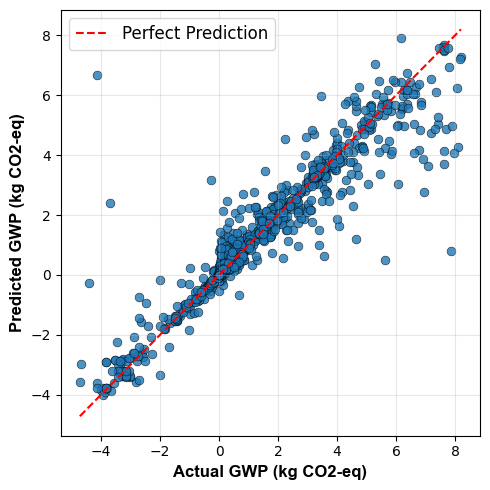

In [41]:
# scatterplot for test set XGboost model and save it in svg format
import matplotlib.pyplot as plt
# no need to zoom in this version
xgb_preds = xgb_best_model.predict(X_test)
y_test   = y_test
#  --- IGNORE ---
fig, ax = plt.subplots(figsize=(5, 5))
# Plot scatter and rasterize the points to keep SVG filesize reasonable
sc = ax.scatter(y_test, xgb_preds, alpha=0.8, s=40, edgecolors='black', linewidth=0.4, rasterized=True)
ax.set_xlabel('Actual GWP (kg CO2-eq)', fontsize=12, fontweight='bold', fontname='Arial')
ax.set_ylabel('Predicted GWP (kg CO2-eq)', fontsize=12, fontweight='bold', fontname='Arial')
# ax.set_title('Scenario C: Prediction vs Actual (Test Set)', fontsize=12, fontweight='bold', fontname='Arial')
#  --- IGNORE ---   
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', linewidth=1.5, label='Perfect Prediction')
ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)
fig.tight_layout()
# Save as SVG (vector) with rasterized points and 300 DPI PNG
fig.savefig("Scenario_C_xgb_scatterplot.svg", format='svg', bbox_inches='tight')
fig.savefig("Scenario_C_xgb_scatterplot.png", format='png', dpi=300, bbox_inches='tight')
print(f"Saved: Scenario_C_xgb_scatterplot.svg and Scenario_C_xgb_scatterplot.png")
plt.show()


C:\Users\user\AppData\Local\Temp\ipykernel_19088\2152322590.py:4: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(y_test, y_pred_xgb_test, c=np.abs(y_test - y_pred_xgb_test) / y_test, cmap='viridis', alpha=0.7)


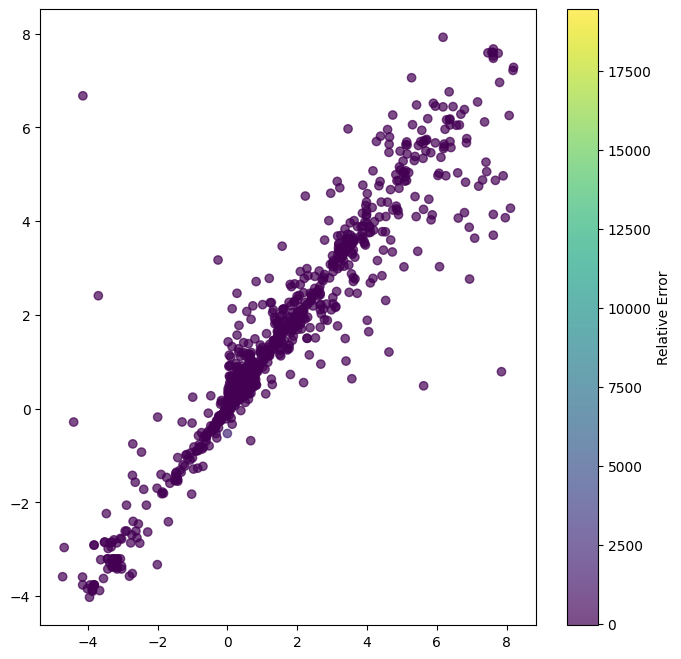

In [12]:
# plot XGB pred vs actual with the color code for relative error
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred_xgb_test, c=np.abs(y_test - y_pred_xgb_test) / y_test, cmap='viridis', alpha=0.7)
plt.colorbar(label='Relative Error')

Saved: xgb_pred_vs_actual.svg and xgb_pred_vs_actual.png


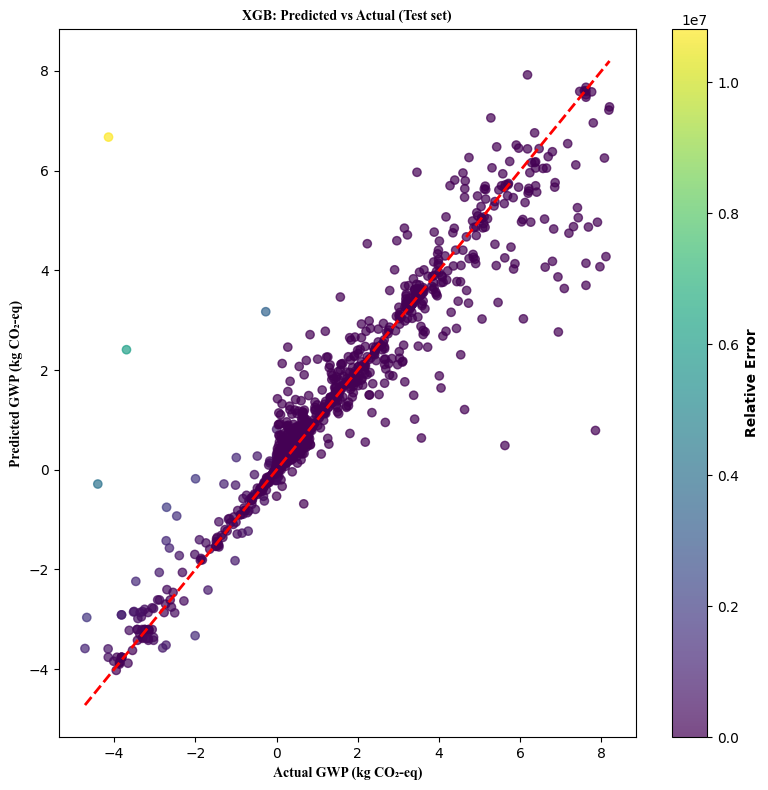

In [13]:
rel_error = np.abs(y_test - y_pred_xgb_test) / np.maximum(y_test, 1e-6)
fig, ax = plt.subplots(figsize=(8, 8))
sc = ax.scatter(y_test, y_pred_xgb_test, c=rel_error, cmap='viridis', alpha=0.7, rasterized=True)
cbar = fig.colorbar(sc)
cbar.set_label('Relative Error', fontweight='bold')
ax.plot([y_test.min(), y_test.max()],
         [y_test.min(), y_test.max()], 'r--', lw=2)  # 45° reference line
ax.set_xlabel("Actual GWP (kg CO₂-eq)", fontsize=10, fontweight='bold', fontname='Times New Roman')
ax.set_ylabel("Predicted GWP (kg CO₂-eq)", fontsize=10, fontweight='bold', fontname='Times New Roman')
ax.set_title("XGB: Predicted vs Actual (Test set)", fontsize=10, fontweight='bold', fontname='Times New Roman')
fig.tight_layout()
# Save as SVG and 300 DPI PNG
fig.savefig("xgb_pred_vs_actual.svg", format='svg', bbox_inches='tight')
fig.savefig("xgb_pred_vs_actual.png", dpi=300, bbox_inches="tight")
print(f"Saved: xgb_pred_vs_actual.svg and xgb_pred_vs_actual.png")
plt.show()


Saved: xgb_pred_vs_actual_validation.svg and xgb_pred_vs_actual_validation.png


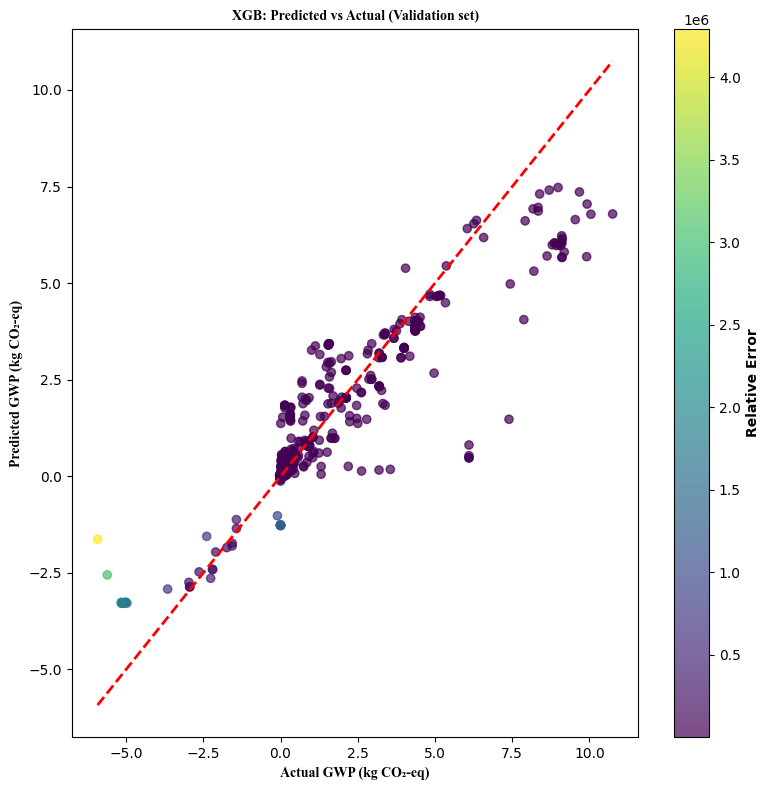

In [14]:
# scatterplot for validation set
rel_error = np.abs(y_ext - y_pred_xgb_ext) / np.maximum(y_ext, 1e-6)
fig, ax = plt.subplots(figsize=(8, 8))
sc = ax.scatter(y_ext, y_pred_xgb_ext, c=rel_error, cmap='viridis', alpha=0.7, rasterized=True)
cbar = fig.colorbar(sc)
cbar.set_label('Relative Error', fontweight='bold')
ax.plot([y_ext.min(), y_ext.max()],
         [y_ext.min(), y_ext.max()], 'r--', lw=2)  # 45° reference line
ax.set_xlabel("Actual GWP (kg CO₂-eq)", fontsize=10, fontweight='bold', fontname='Times New Roman')
ax.set_ylabel("Predicted GWP (kg CO₂-eq)", fontsize=10, fontweight='bold', fontname='Times New Roman')
ax.set_title("XGB: Predicted vs Actual (Validation set)", fontsize=10, fontweight='bold', fontname='Times New Roman')
fig.tight_layout()
# Save as SVG and 300 DPI PNG
fig.savefig("xgb_pred_vs_actual_validation.svg", format='svg', bbox_inches='tight')
fig.savefig("xgb_pred_vs_actual_validation.png", dpi=300, bbox_inches="tight")
print(f"Saved: xgb_pred_vs_actual_validation.svg and xgb_pred_vs_actual_validation.png")
plt.show()


Saved: xgb_pred_vs_actual_validation_by_program_operators_shapes.svg and .png


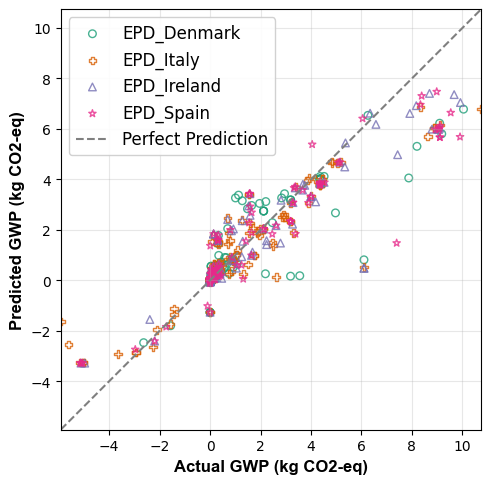


Validation Set Summary by Program Operators:

EPD_Denmark:
  Count: 120
  Actual - Mean: 1.23, Std: 2.22, Range: [-2.63, 10.05]
  Predicted - Mean: 1.08, Std: 1.77, Range: [-2.47, 6.78]
  MAE: 0.56
  RMSE: 1.10
  RMSE: 1.10

EPD_Italy:
  Count: 182
  Actual - Mean: 1.01, Std: 2.42, Range: [-5.92, 10.75]
  Predicted - Mean: 0.95, Std: 1.86, Range: [-3.26, 6.87]
  MAE: 0.49
  RMSE: 0.97
  RMSE: 0.97

EPD_Ireland:
  Count: 148
  Actual - Mean: 1.35, Std: 2.61, Range: [-5.12, 9.92]
  Predicted - Mean: 1.22, Std: 2.05, Range: [-3.28, 7.41]
  MAE: 0.53
  RMSE: 1.05
  RMSE: 1.05

EPD_Spain:
  Count: 153
  Actual - Mean: 1.53, Std: 2.82, Range: [-5.15, 9.91]
  Predicted - Mean: 1.34, Std: 2.15, Range: [-3.28, 7.48]
  MAE: 0.57
  RMSE: 1.08
  RMSE: 1.08


In [40]:
# Scatterplot for validation set with different marker shapes per program operator (country code)
import matplotlib.pyplot as plt
import numpy as np

# Extract country codes from external validation set
country_codes = df_ext['Country code'].values

# Define marker shapes for different country codes (circle, plus, triangle_up, star)
marker_shapes = {
    'DK': 'o',  # circle
    'IT': 'P',  # plus
    'IE': '^',  # triangle_up
    'ES': '*'   # star
}

# Colours for each programme operator (outline colors)
colors = {
    'DK': '#1b9e77',
    'IT': '#d95f02',
    'IE': '#7570b3',
    'ES': '#e7298a'
}

# Define full names for country codes
country_names = {
    'DK': 'EPD_Denmark',
    'IT': 'EPD_Italy',
    'IE': 'EPD_Ireland',
    'ES': 'EPD_Spain'
}

# Create figure
fig, ax = plt.subplots(figsize=(5, 5))

# Plot each country code separately with distinct hollow markers, smaller size and lower alpha
for country in ['DK', 'IT', 'IE', 'ES']:
    mask = country_codes == country
    if mask.sum() > 0:
        ax.scatter(y_ext[mask], y_pred_xgb_ext[mask],
                    marker=marker_shapes.get(country, 'o'),
                    facecolors='none',              # hollow markers
                    edgecolors=colors.get(country, 'black'),
                    label=country_names.get(country, country),
                    alpha=0.8, s=30, linewidth=1.0)

# Add perfect prediction line (1:1)
min_val = min(y_ext.min(), y_pred_xgb_ext.min())
max_val = max(y_ext.max(), y_pred_xgb_ext.max())
ax.plot([min_val, max_val], [min_val, max_val], color='0.5', linestyle='--', lw=1.5, label='Perfect Prediction')

# Axis labels
ax.set_xlabel("Actual GWP (kg CO2-eq)", fontsize=12, fontweight='bold', fontname='Arial')
ax.set_ylabel("Predicted GWP (kg CO2-eq)", fontsize=12, fontweight='bold', fontname='Arial')

# Set equal aspect ratio and limits
ax.set_xlim(min_val, max_val)
ax.set_ylim(min_val, max_val)
ax.set_aspect('equal', adjustable='box')

ax.legend(fontsize=12, loc='upper left', framealpha=0.9)
ax.grid(True, alpha=0.3)
fig.tight_layout()
fig.savefig("xgb_pred_vs_actual_validation_by_program_operators_shapes.svg", format='svg', bbox_inches="tight")
fig.savefig("xgb_pred_vs_actual_validation_by_program_operators_shapes.png", format='png', dpi=300, bbox_inches="tight")
print(f"Saved: xgb_pred_vs_actual_validation_by_program_operators_shapes.svg and .png")
plt.show()

# Print summary statistics by program operators
print("\nValidation Set Summary by Program Operators:")
print("=" * 70)
for country in ['DK', 'IT', 'IE', 'ES']:
    mask = country_codes == country
    if mask.sum() > 0:
        actual_vals = y_ext[mask]
        pred_vals = y_pred_xgb_ext[mask]
        print(f"\n{country_names.get(country, country)}:")
        print(f"  Count: {mask.sum()}")
        print(f"  Actual - Mean: {actual_vals.mean():.2f}, Std: {actual_vals.std():.2f}, Range: [{actual_vals.min():.2f}, {actual_vals.max():.2f}]")
        print(f"  Predicted - Mean: {pred_vals.mean():.2f}, Std: {pred_vals.std():.2f}, Range: [{pred_vals.min():.2f}, {pred_vals.max():.2f}]")
        print(f"  MAE: {np.mean(np.abs(actual_vals - pred_vals)):.2f}")
        print(f"  RMSE: {np.sqrt(np.mean((actual_vals - pred_vals)**2)):.2f}")
        print(f"  RMSE: {np.sqrt(np.mean((actual_vals - pred_vals)**2)):.2f}")
